In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils

In [2]:
import numpy as np

In [3]:
import gudhi
from gudhi import hera
import ot

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='iframe'

from vineyard import *

## VAE

In [71]:
batch_size = 128
latent_size = 80
epochs = 20
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)


In [73]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, latent_size*2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()  # Sigmoid activation to output probabilities
        )
        
    def forward(self, x):
        # Flatten input images
        x = x.view(-1, 784)
        
        # Encode
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        
        # Reparameterization trick
        z = self.reparameterize(mu, logvar)
        
        # Decode
        x_recon = self.decoder(z)
        
        return x_recon, mu, logvar

In [74]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, latent_size)  # 2 for mean and variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()  # Sigmoid activation to output probabilities
        )

    def forward(self, x):
        # Flatten input images
        x = x.view(-1, 784)
        
        h = self.encoder(x)
        
        x_recon = self.decoder(h)
        
        return x_recon

In [75]:
class PCA(nn.Module):
    def __init__(self):
        super(PCA, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, latent_size, bias=False),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 784, bias=False),
        )

    def forward(self, x):
        # Flatten input images
        x = x.view(-1, 784)
        
        h = self.encoder(x)
        
        x_recon = self.decoder(h)
        
        return x_recon

In [77]:
model = AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(recon_x, x, mu=None, logvar=None):
    BCE = nn.BCELoss(reduction='sum')(recon_x, x.view(-1, 784))
    return BCE

    # MSE = nn.MSELoss(reduction='sum')(recon_x, x.view(-1, 784))
    # return MSE
    
    # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # return BCE + KLD

In [208]:
def train(model, optimizer, train_loader, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            
            #recon_batch, mu, logvar = model(data)
            #loss = loss_function(recon_batch, data, mu, logvar)

            recon_batch = model(data)
            loss = loss_function(recon_batch, data)
            
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item()/len(data)}")

        print(f"====> Epoch {epoch+1}/{epochs}, Average Loss: {total_loss / len(train_loader.dataset)}")

train(model, optimizer, train_loader, epochs)

Epoch 1/20, Batch 0, Loss: 96.71956634521484
Epoch 1/20, Batch 100, Loss: 47.334415435791016
Epoch 1/20, Batch 200, Loss: 38.22348403930664
Epoch 1/20, Batch 300, Loss: 31.769845962524414
Epoch 1/20, Batch 400, Loss: 28.501686096191406
====> Epoch 1/20, Average Loss: 40.27866444498698
Epoch 2/20, Batch 0, Loss: 26.269454956054688
Epoch 2/20, Batch 100, Loss: 24.906742095947266
Epoch 2/20, Batch 200, Loss: 21.976699829101562
Epoch 2/20, Batch 300, Loss: 21.81222152709961
Epoch 2/20, Batch 400, Loss: 21.78426742553711
====> Epoch 2/20, Average Loss: 23.04789865722656
Epoch 3/20, Batch 0, Loss: 20.192142486572266
Epoch 3/20, Batch 100, Loss: 20.76357650756836
Epoch 3/20, Batch 200, Loss: 20.736896514892578
Epoch 3/20, Batch 300, Loss: 18.991003036499023
Epoch 3/20, Batch 400, Loss: 18.58841323852539
====> Epoch 3/20, Average Loss: 19.783408935546873
Epoch 4/20, Batch 0, Loss: 19.077533721923828
Epoch 4/20, Batch 100, Loss: 19.029199600219727
Epoch 4/20, Batch 200, Loss: 18.455881118774414

In [15]:
# torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),}, 'pca_model.pth')
checkpoint = torch.load('pca_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

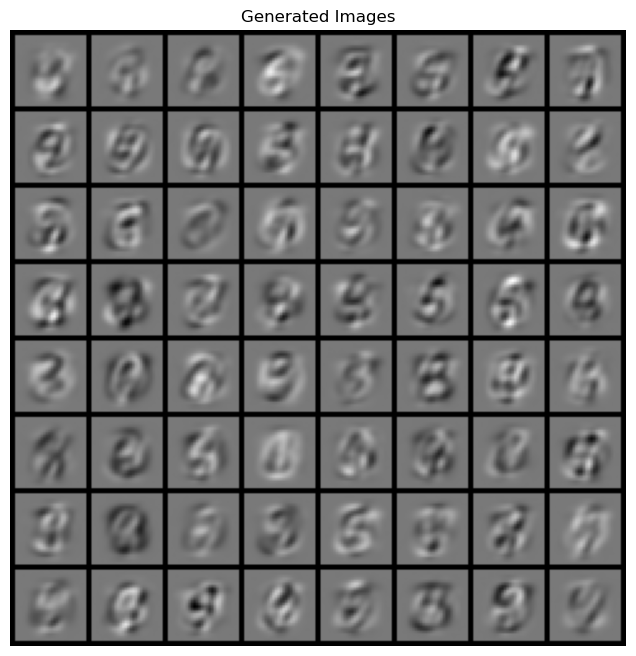

In [16]:
def generate_samples(model, num_samples):
    with torch.no_grad():
        z = torch.randn(num_samples, latent_size).to(device)
        samples = model.decoder(z).cpu()
        samples = samples.view(-1, 1, 28, 28)
        return samples

# Generate and visualize samples
samples = generate_samples(model, 64)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(samples, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()


In [17]:
with open('h_end.npy', 'rb') as file:
    ends = torch.tensor(np.load(file)/255., dtype=torch.float32)

In [18]:
with torch.no_grad():
    embeds = model.encoder(ends.view(-1, 784))

In [19]:
def h_embed(t):
    with torch.no_grad():
        latent = (1-t)*embeds[0:1]+t*embeds[1:2]
        #mu, logvar = torch.chunk(latent, 2, dim=1)
        #z = model.reparameterize(mu, logvar)
        z = latent
        return model.decoder(z).cpu().view(-1, 1, 28, 28)[0,0]
    

In [20]:
ts = np.linspace(0, 1, 100)
hs = [h_embed(t) for t in ts]

In [21]:
stdze = lambda h: (h-torch.min(h))/(torch.max(h)-torch.min(h))
hs = [stdze(h) for h in hs]

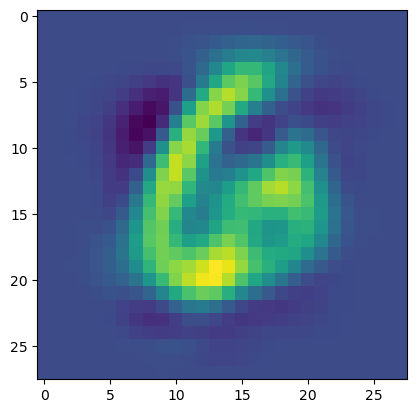

In [22]:
fig, ax = plt.subplots()
im = ax.imshow(hs[0], cmap='viridis', interpolation='nearest')

def init():
    im.set_data(hs[0])
    return [im]

def upd(i):
    im.set_data(hs[i])
    return [im]

ani = FuncAnimation(fig, upd, frames=range(len(ts)),
                    init_func=init, blit=True)

In [23]:
from IPython.display import HTML
HTML(ani.to_html5_video())

## Experiment

In [26]:
fD = lambda D: 1
fL = lambda L: 1

In [27]:
vines = vineyard(ts, np.array(hs)*255, dim=1, verbose=1)
vdist(vines, fD, fL)

10.961909704654007

In [28]:
hsN = np.array([t*(ends[0]*255)+(1-t)*(ends[1]*255) for t in ts]) 
vines = vineyard(ts, hsN, dim=1, verbose=1)
vdist(vines, fD, fL)

9.706916502545209